In [1]:
%env THEANO_FLAGS='device=cpu','floatX=float32'

import os
import os.path as osp

import numpy as np

import theano
import theano.tensor as T
from lasagne import *

%matplotlib nbagg
import matplotlib.pyplot as plt

from mldm import NNWatcher, Net

env: THEANO_FLAGS='device=cpu','floatX=float32'


/home/mborisyak/opt/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
%%sh

wget -q -nc https://raw.githubusercontent.com/amitgroup/amitgroup/master/amitgroup/io/mnist.py

In [3]:
### http://g.sweyla.com/blog/2012/mnist-numpy/
import mnist

In [4]:
%%sh

mkdir -p mnist && {
    cd mnist;
    wget -q -nc http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz &&
    gunzip *.gz
}

gzip: t10k-images-idx3-ubyte already exists;	not overwritten
gzip: t10k-labels-idx1-ubyte already exists;	not overwritten
gzip: train-images-idx3-ubyte already exists;	not overwritten
gzip: train-labels-idx1-ubyte already exists;	not overwritten


In [5]:
X, y = mnist.load_mnist(dataset='training', path='mnist/')
X = X.reshape(-1, 1, 28, 28).astype('float32')

X_test, y_test = mnist.load_mnist(dataset='testing', path='mnist/')
X_test = X_test.reshape(-1, 1, 28, 28).astype('float32')

In [6]:
def one_hot(y, n_classes=10):
    onehot = np.zeros(shape=(y.shape[0], n_classes), dtype='float32')

    onehot[np.arange(y.shape[0]), y] = 1.0
    return onehot

In [7]:
y = one_hot(y)
y_test = one_hot(y_test)

In [8]:
np.prod(X.shape[1:])

784

## Going deep

In [9]:
class DeepDenseMNISTNet(Net):
    def __init__(self, companion_coefs):
        self.X_batch = T.ftensor4(name='X_batch')
        self.y_batch = T.fmatrix(name='y_batch')
        
        self.layers = []
        input_l = layers.InputLayer(shape=(None, ) + X.shape[1:], input_var=self.X_batch, name='Input')
        self.layers.append(input_l)
        
        reshape_l = layers.FlattenLayer(input_l)
        self.layers.append(reshape_l)

        for i, n_units in enumerate([500, 400, 300, 200, 100, 50, 20]):
            dense = layers.DenseLayer(
                self.layers[-1],
                num_units=n_units,
                nonlinearity=nonlinearities.sigmoid,
                name='Dense %d' % i
            )

            self.layers.append(dense)

        self.net = self.layers[-1]
        
        companions = [
            layers.DenseLayer(
                l,
                num_units=10,
                nonlinearity=nonlinearities.softmax,
                name= 'companion %d'
            )
            
            for i, l in enumerate(self.layers[2:])
        ]
        
        companion_predictions = [
            layers.get_output(l)
            for l in companions
        ]
        
        companion_losses = [
            T.mean(objectives.categorical_crossentropy(prediction, self.y_batch))
            for prediction in companion_predictions
        ]
        
        self.pure_loss = companion_losses[-1]
        
        self.loss = reduce(lambda a, b: a + b, [
                c * companion_loss
                for c, companion_loss in zip(companion_coefs, companion_losses)
        ])
        
        self.regularization = regularization.regularize_network_params(
            self.net, penalty=regularization.l2
        )

        self.regularization_coef = T.fscalar('regularization_coef')
        
        self.loss = self.loss + self.regularization_coef * self.regularization
        
        self.learning_rate = T.fscalar('learning rate')
        params = layers.get_all_params(self.net)

        upd = updates.adadelta(self.loss, params, learning_rate=self.learning_rate)

        self.train = theano.function(
            [self.X_batch, self.y_batch, self.regularization_coef, self.learning_rate],
            companion_losses,
            updates=upd
        )
        
        self.predict = theano.function(
            [self.X_batch],
            companion_predictions[-1]
        )

        self.get_loss = theano.function([self.X_batch, self.y_batch], self.pure_loss)
        
        super(DeepDenseMNISTNet, self).__init__()
        
    @staticmethod
    def batch_stream(n, batch_size=32):
        n_batches = n / batch_size
        
        for i in xrange(n_batches):
            indx = np.random.choice(n, size=batch_size)
            yield indx
    
    def fit(self, X, y, n_epoches = 1, batch_size=32, regularization_coef=1.0e-6, learning_rate = 1.0):
        regularization_coef = np.float32(regularization_coef)
        learning_rate = np.float32(learning_rate)
        
        n_batches = X.shape[0] / batch_size
        losses = [
            np.zeros(shape=(n_epoches, n_batches), dtype='float32')
            for _ in range(7)
        ]
        
        for epoch in xrange(n_epoches):
            for i, indx in enumerate(self.batch_stream(X.shape[0], batch_size=batch_size)):
                ls = self.train(X[indx], y[indx], regularization_coef, learning_rate)
            
                for l, history in zip(ls, losses):
                    history[epoch, i] = l
            
            yield [ h[:(epoch + 1)] for h in losses ]

In [10]:
companion_coefs = np.exp(np.linspace(-3, 0, num=7))
print companion_coefs

deep_net = DeepDenseMNISTNet(companion_coefs)

[ 0.04978707  0.082085    0.13533528  0.22313016  0.36787944  0.60653066
  1.        ]


In [11]:
deep_net.save('deep-net-0.npz')

<IPython.core.display.Javascript object>


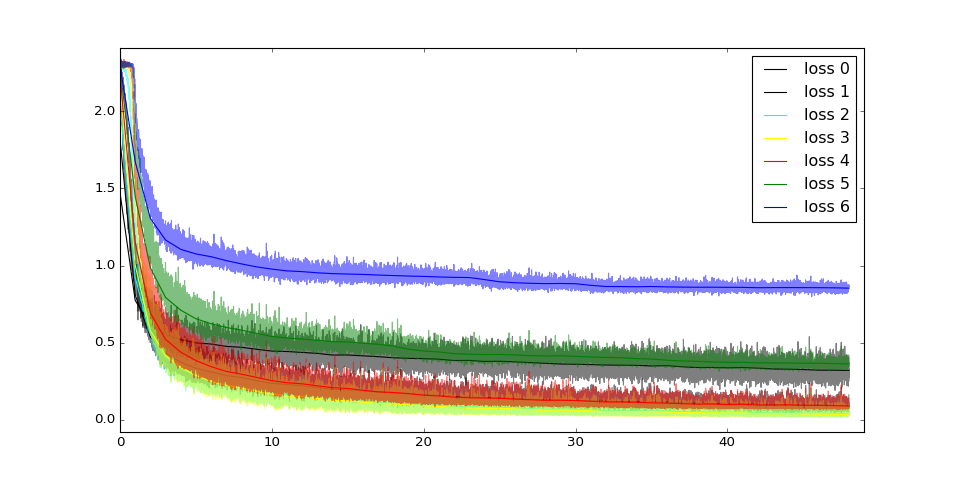

In [12]:
watcher = NNWatcher(
    labels=[ ('loss %d' % i) for i in range(7) ],
    colors=['black', 'black', 'cyan', 'yellow', 'red', 'green', 'blue']
)

In [13]:
for loss in deep_net.fit(X, y, n_epoches=64, batch_size=128, regularization_coef=1.0e-7):
    watcher.draw(*loss)

KeyboardInterrupt: 

In [ ]:
np.log(10)

In [ ]:
W = layers.get_all_layers(deep_net.net)[2].get_params()[0].get_value()

In [ ]:
import itertools

n = 5
fig, ax = plt.subplots(n, n, figsize=(12, 12))

vmax = np.max(np.abs(W))
vmin = np.min(np.abs(W))

for i, j in itertools.product(range(n), range(n)):
    k = i * n + j
    ax[i, j].imshow(
        W[:, k].reshape(28, 28),
        interpolation='None', cmap=plt.cm.viridis,
        vmin=vmin, vmax = vmax
    )

plt.tight_layout()